# Introduction

This notebook will be used only to analyze data from the SciPy execution of Leaflet Finder. The experiment setup is as follows:

1. Execution was done on Comet.
2. The core count was 64,256,1024 cores
3. One CU/task per core
4. The calculation was done over 131072 atoms and the whole matrix was calculated.
5. The produced matrix was aggregated to a single Unit to calculate the connected components.

In [61]:
%matplotlib inline
import numpy as np
import matplotlib
matplotlib.use('Qt5Agg')
from matplotlib import pyplot as plt
import csv
import pandas

In [2]:
def CsvToPandas(csvfile):
    csv_data = list()
    for row in csvfile:
        if row[0].startswith('unit.'):
            csv_data.append(float(row[-2]))
    csvdata=np.array(csv_data)
    return csvdata.max()

In [3]:
def SparkLogToDataFrame(filename,path):
    import json
    import pandas
    import numpy as np

    columns=['StageID','TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize']

    stat_file=open(path+filename)
    stats=list();
    for line in stat_file:
        stats.append(json.loads(line))

    data=pandas.DataFrame(columns=columns,dtype=np.int64)
    data_point = np.zeros((1,9),dtype=np.int64)
    for stat in stats:
        if stat['Event'] == 'SparkListenerTaskEnd':
            data_point[0,0] = int(stat['Stage ID'])
            data_point[0,1] = int(stat['Task Info']['Task ID'])
            data_point[0,2] = int(stat['Task Info']['Launch Time'])
            data_point[0,4] = int(stat['Task Metrics']['Executor Deserialize Time'])
            data_point[0,5] = int(stat['Task Metrics']['Executor Run Time'])
            data_point[0,6] = int(stat['Task Metrics']['Result Serialization Time'])
            data_point[0,7] = int(stat['Task Info']['Finish Time'])
            data_point[0,8] = int(stat['Task Metrics']['Result Size'])
            data_point[0,3] = data_point[0,7] - (data_point[0,2] + data_point[0,4] \
                                           + data_point[0,5] + data_point[0,6])
            data_case = pandas.DataFrame(data_point,columns=columns)
            data = data.append(data_case,ignore_index=True)
            
    return data


In [4]:
def SparkSessionToDataFrame(sessionName,path,appName):
    import json
    import pandas
    import numpy as np

    columns=['TaskId','LaunchTime','SchedulerDelay','DeserializeTime','Runtime','ResultSerialization','FinishTime','ResultSize','ReadTime','Exec']
    data=pandas.DataFrame(np.zeros((1,10)),columns=columns,dtype=np.int64)
    data_point = np.zeros((10,1),dtype=np.int64)
    
    if appName != 'miss':
        appPath = path + sessionName + '/' + appName
        print appPath
        timings = np.load(path + sessionName + '/timing.npz.npy')

        stat_file=open(appPath)
        stats=list();
        for line in stat_file:
            stats.append(json.loads(line))

        for stat in stats:
            if stat['Event'] == 'SparkListenerTaskEnd':
                data_point[0] = int(stat['Task Info']['Task ID'])
                data_point[1] = int(stat['Task Info']['Launch Time'])
                data_point[3] = int(stat['Task Metrics']['Executor Deserialize Time'])
                data_point[4] = int(stat['Task Metrics']['Executor Run Time'])
                data_point[5] = int(stat['Task Metrics']['Result Serialization Time'])
                data_point[6] = int(stat['Task Info']['Finish Time'])
                data_point[7] = int(stat['Task Metrics']['Result Size'])
                data_point[2] = data_point[6] - (data_point[1] + data_point[3] \
                                           + data_point[4] + data_point[5])
                data_point[8] = timings[data_point[0],1]-timings[data_point[0],0]
                data_point[9] = timings[data_point[0],2]-timings[data_point[0],1]
                data_case = pandas.DataFrame(data_point.reshape((1,10)),columns=columns)
                data = data.append(data_case,ignore_index=True)
            
    return data

In [5]:
def SessionToPandas(path,sessionName,cores):
    
    unit_path = path+sessionName+'/'
    
    sessionDataFrame = pandas.DataFrame(columns=['Read','Exec','Write'],dtype=np.float)
    for i in range(0,cores):
        data_point = np.zeros((1,3),dtype=np.float)
        stdoutFile = open(unit_path + 'unit.%06i'%i+'/STDOUT')
        for line in stdoutFile:
            if line.startswith('Data Read:'):
                lineList=line.split()
                data_point[0,0] = np.float(lineList[2])
                data_point[0,1] = np.float(lineList[5])
            elif line.startswith('Total Time'):
                lineList = line.split()
                data_point[0,2] = np.float(lineList[6]) - data_point[0,0] - data_point[0,1]
            
        sessionDataFrame = sessionDataFrame.append(pandas.DataFrame((data_point),columns=['Read','Exec','Write']),ignore_index=True)
            
    return sessionDataFrame

# 1. Vanilla Experiments

## 1.1 Setting up everything

In [6]:
rp_lf_64_16384_1 = pandas.DataFrame.from_csv('Vanilla/Iteration7/rplfco_64_1.csv',index_col=None)
rp_lf_64_16384_2 = pandas.DataFrame.from_csv('Vanilla/Iteration7/rplfco_64_2.csv',index_col=None)
rp_lf_64_16384_3 = pandas.DataFrame.from_csv('Vanilla/Iteration7/rplfco_64_3.csv',index_col=None)
rp_lf_256_8192_1 = pandas.DataFrame.from_csv('Vanilla/Iteration7/rplfco_256_1.csv',index_col=None)
rp_lf_256_8192_2 = pandas.DataFrame.from_csv('Vanilla/Iteration7/rplfco_256_2.csv',index_col=None)
rp_lf_256_8192_3 = pandas.DataFrame.from_csv('Vanilla/Iteration7/rplfco_256_3.csv',index_col=None)


In [7]:
rp_lf_64_16384_tmp = pandas.concat([rp_lf_64_16384_1,rp_lf_64_16384_2,rp_lf_64_16384_3],ignore_index=True)
rp_lf_256_8192_tmp = pandas.concat([rp_lf_256_8192_1,rp_lf_256_8192_2,rp_lf_256_8192_3],ignore_index=True)

In [8]:
rp_lf=pandas.DataFrame(columns=['Overhead','ExecDist','DataMove','CompExec'])

stageInPending=np.mean([(rp_lf_64_16384_1[0:-1]['StageIn']).max(),\
                        (rp_lf_64_16384_2[0:-1]['StageIn']).max(),\
                        (rp_lf_64_16384_3[0:-1]['StageIn']).max()])
StageIn =      np.mean([(rp_lf_64_16384_1[0:-1]['Allocate']-    rp_lf_64_16384_1[0:-1]['StageIn']),\
                        (rp_lf_64_16384_2[0:-1]['Allocate']-    rp_lf_64_16384_2[0:-1]['StageIn']),\
                        (rp_lf_64_16384_3[0:-1]['Allocate']-    rp_lf_64_16384_3[0:-1]['StageIn'])])                 
allocate =     np.mean([(rp_lf_64_16384_1[0:-1]['Exec']-        rp_lf_64_16384_1[0:-1]['Allocate']),\
                        (rp_lf_64_16384_2[0:-1]['Exec']-        rp_lf_64_16384_2[0:-1]['Allocate']),\
                        (rp_lf_64_16384_3[0:-1]['Exec']-        rp_lf_64_16384_3[0:-1]['Allocate'])])
Exec=          np.mean([(rp_lf_64_16384_1[0:-1]['StageOut']-    rp_lf_64_16384_1[0:-1]['Exec']),\
                        (rp_lf_64_16384_2[0:-1]['StageOut']-    rp_lf_64_16384_2[0:-1]['Exec']),\
                        (rp_lf_64_16384_3[0:-1]['StageOut']-    rp_lf_64_16384_3[0:-1]['Exec'])])      
dataMovement = np.mean([(rp_lf_64_16384_1.iloc[64]['Exec']-    (rp_lf_64_16384_1[0:-1]['StageOut'].max())),\
                        (rp_lf_64_16384_2.iloc[64]['Exec']-    (rp_lf_64_16384_2[0:-1]['StageOut'].max())),\
                        (rp_lf_64_16384_3.iloc[64]['Exec']-    (rp_lf_64_16384_3[0:-1]['StageOut'].max()))])
connX =        np.mean([(rp_lf_64_16384_1.iloc[64]['StageOut']- rp_lf_64_16384_1.iloc[64]['Exec']),\
                        (rp_lf_64_16384_2.iloc[64]['StageOut']- rp_lf_64_16384_2.iloc[64]['Exec']),\
                        (rp_lf_64_16384_3.iloc[64]['StageOut']- rp_lf_64_16384_3.iloc[64]['Exec'])])
rp_lf.loc[64]=np.array([stageInPending+StageIn+allocate,Exec,dataMovement,connX])


stageInPending=np.mean([(rp_lf_256_8192_1[0:-1]['StageIn']).max(),\
                        (rp_lf_256_8192_2[0:-1]['StageIn']).max(),\
                        (rp_lf_256_8192_3[0:-1]['StageIn']).max()])
StageIn =      np.mean([(rp_lf_256_8192_1[0:-1]['Allocate']-    rp_lf_256_8192_1[0:-1]['StageIn']),\
                        (rp_lf_256_8192_2[0:-1]['Allocate']-    rp_lf_256_8192_2[0:-1]['StageIn']),\
                        (rp_lf_256_8192_3[0:-1]['Allocate']-    rp_lf_256_8192_3[0:-1]['StageIn'])])                 
allocate =     np.mean([(rp_lf_256_8192_1[0:-1]['Exec']-        rp_lf_256_8192_1[0:-1]['Allocate']),\
                        (rp_lf_256_8192_2[0:-1]['Exec']-        rp_lf_256_8192_2[0:-1]['Allocate']),\
                        (rp_lf_256_8192_3[0:-1]['Exec']-        rp_lf_256_8192_3[0:-1]['Allocate'])])
Exec=          np.mean([(rp_lf_256_8192_1[0:-1]['StageOut']-    rp_lf_256_8192_1[0:-1]['Exec']),\
                        (rp_lf_256_8192_2[0:-1]['StageOut']-    rp_lf_256_8192_2[0:-1]['Exec']),\
                        (rp_lf_256_8192_3[0:-1]['StageOut']-    rp_lf_256_8192_3[0:-1]['Exec'])])      
dataMovement = np.mean([(rp_lf_256_8192_1.iloc[256]['Exec']-    (rp_lf_256_8192_1[0:-1]['StageOut'].max())),\
                        (rp_lf_256_8192_2.iloc[256]['Exec']-    (rp_lf_256_8192_2[0:-1]['StageOut'].max())),\
                        (rp_lf_256_8192_3.iloc[256]['Exec']-    (rp_lf_256_8192_3[0:-1]['StageOut'].max()))])
connX =        np.mean([(rp_lf_256_8192_1.iloc[256]['StageOut']- rp_lf_256_8192_1.iloc[256]['Exec']),\
                        (rp_lf_256_8192_2.iloc[256]['StageOut']- rp_lf_256_8192_2.iloc[256]['Exec']),\
                        (rp_lf_256_8192_3.iloc[256]['StageOut']- rp_lf_256_8192_3.iloc[256]['Exec'])])
rp_lf.loc[256]=np.array([stageInPending+StageIn+allocate,Exec,dataMovement,connX])

In [9]:
rpsc_lf_64_16384_1 = pandas.DataFrame.from_csv('Vanilla/SciPyIter1/lfscipyvan_64_1.csv',index_col=None)
rpsc_lf_64_16384_2 = pandas.DataFrame.from_csv('Vanilla/SciPyIter1/lfscipyvan_64_2.csv',index_col=None)
rpsc_lf_64_16384_3 = pandas.DataFrame.from_csv('Vanilla/SciPyIter1/lfscipyvan_64_3.csv',index_col=None)
rpsc_lf_256_8192_1 = pandas.DataFrame.from_csv('Vanilla/SciPyIter1/lfscipyvan_256_1.csv',index_col=None)
rpsc_lf_256_8192_2 = pandas.DataFrame.from_csv('Vanilla/SciPyIter1/lfscipyvan_256_2.csv',index_col=None)
rpsc_lf_256_8192_3 = pandas.DataFrame.from_csv('Vanilla/SciPyIter1/lfscipyvan_256_3.csv',index_col=None)
rpsc_lf_1024_4096_1 = pandas.DataFrame.from_csv('Vanilla/SciPyIter1/lfscipyvan_1024_1.csv',index_col=None)
rpsc_lf_1024_4096_2 = pandas.DataFrame.from_csv('Vanilla/SciPyIter1/lfscipyvan_1024_2.csv',index_col=None)
rpsc_lf_1024_4096_3 = pandas.DataFrame.from_csv('Vanilla/SciPyIter1/lfscipyvan_1024_3.csv',index_col=None)

In [46]:
rpsc_lf=pandas.DataFrame(columns=['RADICAL-Pilot Overhead','RADICAL-Pilot ExecDist','RADICAL-Pilot DataMove','RADICAL-Pilot CompExec'])
stageInPending=np.mean([(rpsc_lf_64_16384_1[0:-1]['StageIn']).max(),\
                        (rpsc_lf_64_16384_2[0:-1]['StageIn']).max(),\
                        (rpsc_lf_64_16384_3[0:-1]['StageIn']).max()])
StageIn =      np.mean([(rpsc_lf_64_16384_1[0:-1]['Allocate']-    rpsc_lf_64_16384_1[0:-1]['StageIn']),\
                        (rpsc_lf_64_16384_2[0:-1]['Allocate']-    rpsc_lf_64_16384_2[0:-1]['StageIn']),\
                        (rpsc_lf_64_16384_3[0:-1]['Allocate']-    rpsc_lf_64_16384_3[0:-1]['StageIn'])])                 
allocate =     np.mean([(rpsc_lf_64_16384_1[0:-1]['Exec']-        rpsc_lf_64_16384_1[0:-1]['Allocate']),\
                        (rpsc_lf_64_16384_2[0:-1]['Exec']-        rpsc_lf_64_16384_2[0:-1]['Allocate']),\
                        (rpsc_lf_64_16384_3[0:-1]['Exec']-        rpsc_lf_64_16384_3[0:-1]['Allocate'])])
Exec=          np.mean([(rpsc_lf_64_16384_1[0:-1]['StageOut']-    rpsc_lf_64_16384_1[0:-1]['Exec']),\
                        (rpsc_lf_64_16384_2[0:-1]['StageOut']-    rpsc_lf_64_16384_2[0:-1]['Exec']),\
                        (rpsc_lf_64_16384_3[0:-1]['StageOut']-    rpsc_lf_64_16384_3[0:-1]['Exec'])])      
dataMovement = np.mean([(rpsc_lf_64_16384_1.iloc[64]['Exec']-    (rpsc_lf_64_16384_1[0:-1]['StageOut'].max())),\
                        (rpsc_lf_64_16384_2.iloc[64]['Exec']-    (rpsc_lf_64_16384_2[0:-1]['StageOut'].max())),\
                        (rpsc_lf_64_16384_3.iloc[64]['Exec']-    (rpsc_lf_64_16384_3[0:-1]['StageOut'].max()))])
connX =        np.mean([(rpsc_lf_64_16384_1.iloc[64]['StageOut']- rpsc_lf_64_16384_1.iloc[64]['Exec']),\
                        (rpsc_lf_64_16384_2.iloc[64]['StageOut']- rpsc_lf_64_16384_2.iloc[64]['Exec']),\
                        (rpsc_lf_64_16384_3.iloc[64]['StageOut']- rpsc_lf_64_16384_3.iloc[64]['Exec'])])
rpsc_lf.loc[64]=np.array([stageInPending+StageIn+allocate,Exec,dataMovement,connX])


stageInPending=np.mean([(rpsc_lf_256_8192_1[0:-1]['StageIn']).max(),\
                        (rpsc_lf_256_8192_2[0:-1]['StageIn']).max(),\
                        (rpsc_lf_256_8192_3[0:-1]['StageIn']).max()])
StageIn =      np.mean([(rpsc_lf_256_8192_1[0:-1]['Allocate']-     rpsc_lf_256_8192_1[0:-1]['StageIn']),\
                        (rpsc_lf_256_8192_2[0:-1]['Allocate']-     rpsc_lf_256_8192_2[0:-1]['StageIn']),\
                        (rpsc_lf_256_8192_3[0:-1]['Allocate']-     rpsc_lf_256_8192_3[0:-1]['StageIn'])])                 
allocate =     np.mean([(rpsc_lf_256_8192_1[0:-1]['Exec']-         rpsc_lf_256_8192_1[0:-1]['Allocate']),\
                        (rpsc_lf_256_8192_2[0:-1]['Exec']-         rpsc_lf_256_8192_2[0:-1]['Allocate']),\
                        (rpsc_lf_256_8192_3[0:-1]['Exec']-         rpsc_lf_256_8192_3[0:-1]['Allocate'])])
Exec=          np.mean([(rpsc_lf_256_8192_1[0:-1]['StageOut']-     rpsc_lf_256_8192_1[0:-1]['Exec']),\
                        (rpsc_lf_256_8192_2[0:-1]['StageOut']-     rpsc_lf_256_8192_2[0:-1]['Exec']),\
                        (rpsc_lf_256_8192_3[0:-1]['StageOut']-     rpsc_lf_256_8192_3[0:-1]['Exec'])])      
dataMovement = np.mean([(rpsc_lf_256_8192_1.iloc[256]['Exec']-    (rpsc_lf_256_8192_1[0:-1]['StageOut'].max())),\
                        (rpsc_lf_256_8192_2.iloc[256]['Exec']-    (rpsc_lf_256_8192_2[0:-1]['StageOut'].max())),\
                        (rpsc_lf_256_8192_3.iloc[256]['Exec']-    (rpsc_lf_256_8192_3[0:-1]['StageOut'].max()))])
connX =        np.mean([(rpsc_lf_256_8192_1.iloc[256]['StageOut']- rpsc_lf_256_8192_1.iloc[256]['Exec']),\
                        (rpsc_lf_256_8192_2.iloc[256]['StageOut']- rpsc_lf_256_8192_2.iloc[256]['Exec']),\
                        (rpsc_lf_256_8192_3.iloc[256]['StageOut']- rpsc_lf_256_8192_3.iloc[256]['Exec'])])
rpsc_lf.loc[256]=np.array([stageInPending+StageIn+allocate,Exec,dataMovement,connX])

stageInPending=np.mean([(rpsc_lf_1024_4096_1[0:-1]['StageIn']).max(),\
                        (rpsc_lf_1024_4096_2[0:-1]['StageIn']).max(),\
                        (rpsc_lf_1024_4096_3[0:-1]['StageIn']).max()])
StageIn =      np.mean([(rpsc_lf_1024_4096_1[0:-1]['Allocate']-     rpsc_lf_1024_4096_1[0:-1]['StageIn']),\
                        (rpsc_lf_1024_4096_2[0:-1]['Allocate']-     rpsc_lf_1024_4096_2[0:-1]['StageIn']),\
                        (rpsc_lf_1024_4096_3[0:-1]['Allocate']-     rpsc_lf_1024_4096_3[0:-1]['StageIn'])])                 
allocate =     np.mean([(rpsc_lf_1024_4096_1[0:-1]['Exec']-         rpsc_lf_1024_4096_1[0:-1]['Allocate']),\
                        (rpsc_lf_1024_4096_2[0:-1]['Exec']-         rpsc_lf_1024_4096_2[0:-1]['Allocate']),\
                        (rpsc_lf_1024_4096_3[0:-1]['Exec']-         rpsc_lf_1024_4096_3[0:-1]['Allocate'])])
Exec=          np.mean([(rpsc_lf_1024_4096_1[0:-1]['StageOut']-     rpsc_lf_1024_4096_1[0:-1]['Exec']),\
                        (rpsc_lf_1024_4096_2[0:-1]['StageOut']-     rpsc_lf_1024_4096_2[0:-1]['Exec']),\
                        (rpsc_lf_1024_4096_3[0:-1]['StageOut']-     rpsc_lf_1024_4096_3[0:-1]['Exec'])])      
dataMovement = np.mean([(rpsc_lf_1024_4096_1.iloc[1024]['Exec']-    (rpsc_lf_1024_4096_1[0:-1]['StageOut'].max())),\
                        (rpsc_lf_1024_4096_2.iloc[1024]['Exec']-    (rpsc_lf_1024_4096_2[0:-1]['StageOut'].max())),\
                        (rpsc_lf_1024_4096_3.iloc[1024]['Exec']-    (rpsc_lf_1024_4096_3[0:-1]['StageOut'].max()))])
connX =        np.mean([(rpsc_lf_1024_4096_1.iloc[1024]['StageOut']- rpsc_lf_1024_4096_1.iloc[1024]['Exec']),\
                        (rpsc_lf_1024_4096_2.iloc[1024]['StageOut']- rpsc_lf_1024_4096_2.iloc[1024]['Exec']),\
                        (rpsc_lf_1024_4096_3.iloc[1024]['StageOut']- rpsc_lf_1024_4096_3.iloc[1024]['Exec'])])
rpsc_lf.loc[1024]=np.array([stageInPending+StageIn+allocate,Exec,dataMovement,connX])

In [47]:
rpsc_lf

,RADICAL-Pilot Overhead,RADICAL-Pilot ExecDist,RADICAL-Pilot DataMove,RADICAL-Pilot CompExec
64,6.300298,42.014193,9.346097,73.865654
256,125.404087,21.359088,7.504659,72.268781
1024,83.026851,8.824270,11.548451,81.367286


## Dataframes for statistics

# Spark Experiments

In [15]:
spsc_lf = pandas.DataFrame.from_csv('Spark/ScipyDist/reports_comet_20_1_2017.csv')
spsc_lf

,Cores,Try,Overhead,AdjMatrix,ConnComp,SessionName,JsonName
Index,,,,,,,
0,64,1,5.394496,225.805678,48.119440,spcolfsci_64_1,app-20170119202928-0000
1,64,2,5.397450,233.837047,48.067829,spcolfsci_64_2,app-20170119203612-0000
2,64,3,7.751938,167.612077,45.645021,spcolfsci_64_3,app-20170119204755-0000
3,256,1,5.532979,99.788715,48.155485,spcolfsci_256_1,app-20170119210153-0000
4,256,2,5.398422,100.137922,47.989407,spcolfsci_256_2,app-20170119210557-0000
5,256,3,5.394899,101.286997,48.043367,spcolfsci_256_3,app-20170119210956-0000
6,1024,1,5.405507,63.950578,47.001645,spcolfsci_1024_1,app-20170119212058-0000
7,1024,2,5.405419,61.308205,47.408331,spcolfsci_1024_2,app-20170119212518-0000
8,1024,3,5.572604,61.105932,46.823276,spcolfsci_1024_3,app-20170119213304-0000


In [34]:
sp_sc_fl=pandas.DataFrame(columns=['Pilot-Spark Overhead','Pilot-Spark ExecDist','Pilot-Spark CompExec'])
overhead = spsc_lf['Overhead'][0:3].mean()
adjmatrx = spsc_lf['AdjMatrix'][0:3].mean()
conncomp = spsc_lf['ConnComp'][0:3].mean()
sp_sc_fl.loc[64] = [overhead,adjmatrx,conncomp]

overhead = spsc_lf['Overhead'][3:6].mean()
adjmatrx = spsc_lf['AdjMatrix'][3:6].mean()
conncomp = spsc_lf['ConnComp'][3:6].mean()
sp_sc_fl.loc[256] = [overhead,adjmatrx,conncomp]

overhead = spsc_lf['Overhead'][6:9].mean()
adjmatrx = spsc_lf['AdjMatrix'][6:9].mean()
conncomp = spsc_lf['ConnComp'][6:9].mean()
sp_sc_fl.loc[1024] = [overhead,adjmatrx,conncomp]

sp_sc_fl

,Pilot-Spark Overhead,Pilot-Spark ExecDist,Pilot-Spark CompExec
64,6.181295,209.084934,47.277430
256,5.442100,100.404545,48.062753
1024,5.461177,62.121572,47.077751


# Plotting

     Overhead     ExecDist  DataMove    CompExec
64   6.292412  1640.831033  7.083892   95.919802
256  9.635476   442.524485  6.956130  110.400523
       Overhead   ExecDist  DataMove   CompExec
64     6.300298  42.014193  9.346097  73.865654
256  125.404087  21.359088  7.504659  72.268781


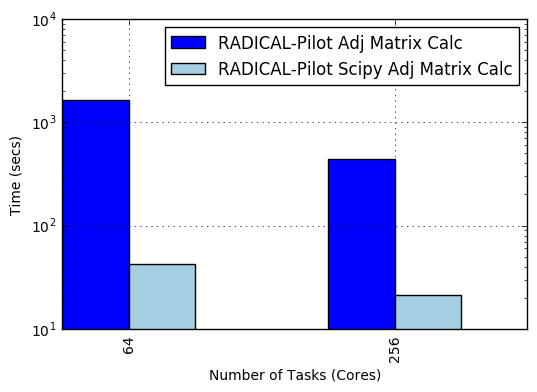

In [25]:
width=0.25
fig, axes = plt.subplots(nrows=1, ncols=1)
rp_lf.plot(y=['ExecDist'],kind='bar',stacked=True,ax=axes,sharey=False,sharex=True,width=width,position=1,grid=True,legend=True,log=1)
rpsc_lf.plot(y=['ExecDist'],kind='bar',stacked=True,ax=axes,sharey=True,sharex=True,width=width,position=0,grid=True,legend=True,colormap='Paired')
axes.legend(['RADICAL-Pilot Adj Matrix Calc',\
             'RADICAL-Pilot Scipy Adj Matrix Calc'],
            loc='best')
#sp_haus_short_plot.plot(kind='bar',stacked=True,ax=axes,sharey=False,sharex=True,width=width,position=0,grid=True,legend=False,colormap='Paired')
#plt.title('Mean Task BreakDown. Small Trajectory, Comet, 12/9/2016')
plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Time (secs)')
plt.savefig('leafletfinder_rp_scipyAdjM_comet131k.png',dpi=800,bbox_inches='tight')
plt.savefig('leafletfinder_rp_scipyAdjM_comet131k.pdf',dpi=800,bbox_inches='tight')
print rp_lf
print rpsc_lf

,Pilot-Spark Overhead,Pilot-Spark ExecDist,Pilot-Spark CompExec
64,6.181295,209.084934,47.277430
256,5.442100,100.404545,48.062753
1024,5.461177,62.121572,47.077751


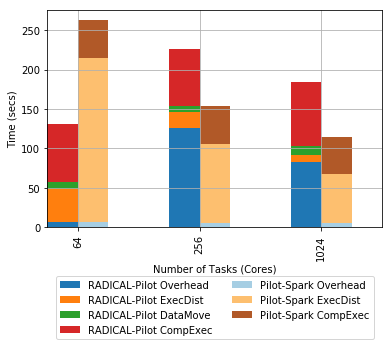

In [62]:
width=0.25
fig, axes = plt.subplots(nrows=1, ncols=1)
rpsc_lf.plot(kind='bar',stacked=True,ax=axes,sharey=False,sharex=True,width=width,position=1,grid=True,legend=True)
sp_sc_fl.plot(kind='bar',stacked=True,ax=axes,sharey=True,sharex=True,width=width,position=0,grid=True,legend=True,colormap='Paired')
#sp_haus_short_plot.plot(kind='bar',stacked=True,ax=axes,sharey=False,sharex=True,width=width,position=0,grid=True,legend=False,colormap='Paired')
#plt.title('Mean Task BreakDown. Small Trajectory, Comet, 12/9/2016')
plt.xlabel('Number of Tasks (Cores)')
plt.ylabel('Time (secs)')
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),
          fancybox=True, ncol=2)
plt.savefig('lfrp_sparkScipy_comet131k2.png',dpi=800,bbox_inches='tight')
plt.savefig('lfrp_sparkScipy_comet131k2.pdf',dpi=800,bbox_inches='tight')
sp_sc_fl

In [60]:
matplotlib.backends.backend

'module://ipykernel.pylab.backend_inline'